In [2]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
import random
import glob
import CNN_Module as cnn_module
import models
import DataGenerator_3d
import time

Using TensorFlow backend.


In [3]:
import imp
imp.reload(cnn_module)
imp.reload(models)

<module 'models' from '/home/ubuntu/data/code/Modules/models.py'>

In [4]:
sequence_length = 10
model = models.get_luke_3d_model(input_shape=(140,100,1),sequence_length=sequence_length)

augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(140,100,augment_train,augment_valid)
params_train['dim']=(sequence_length,140,100)
params_test['dim']=(sequence_length,140,100)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


696
78


In [6]:
result_val_acc = []
result_acc =[]
times = []

video_path = '/cropped_video100_140'
depth = 10
sequence_length=10 
sample_gap=10 
epochs=30
stepsperepoch=100

for repeat in np.arange(0,1):
    start = time.time()
    
    print('repeat =', repeat)
    #prep cells for feeding into CNN
    control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/resistant/'))
    sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/susceptible/'))

    #label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
    control_cells_label = cnn_module.create_label_dict(control_cells,0)
    sus_cells_label     = cnn_module.create_label_dict(sus_cells,1)

    train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.9)
    train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.9)

    train_labels = train_ctrl+train_sus
    test_labels = test_ctrl+test_sus
    
    print(len(train_labels))
    print(len(test_labels))

    #im_paths_train, im_labels_train = cnn_module.get_labels_images_3d(train_labels,test_labels,video_path,sample_gap,depth)
    im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images_3d(train_labels,test_labels,video_path,sample_gap,depth)
    #random.shuffle(im_paths_train)
    #random.shuffle(im_paths_test)

    augment_train, augment_valid = cnn_module.get_augmentations_train_test()

    model = models.get_luke_3d_model(input_shape=(140,100,1),sequence_length=sequence_length)
    validate_steps = len(im_paths_test)//32
    
    training_generator = DataGenerator_3d.DataGenerator(im_paths_train, im_labels_train, **params_train,depth=depth)
    prediction_generator = DataGenerator_3d.DataGenerator(im_paths_test, im_labels_test, **params_test,depth=depth)
    #print(params_train)
    
    #get kfold predictions from training set 
    print('kfold training')
    train_preds, kfold_val_acc, kfold_acc, kfold_val_loss, kfold_loss = cnn_module.k_fold_train_3d2(train_labels,video_path,model,sample_gap,epochs,stepsperepoch,params_train,params_test,depth,sequence_length)    
    print('final training')
    
    #fully train a model to make predictions on the test set
    fully_train_model = cnn_module.fit_model(model,training_generator,prediction_generator,epochs,stepsperepoch,validate_steps,params_train,params_test)
    test_predictions = cnn_module.predict(test_labels,video_path,fully_train_model,sample_gap,params_test)
    
    run_val_acc = model.history.history['val_acc']
    run_acc = model.history.history['acc']
    end = time.time()
    run_time = end-start
    print(run_time)
    
    result_val_acc.append(run_val_acc)
    result_acc.append(run_acc)
    times.append(run_time)

repeat = 0
458
52
kfold training
92
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



Epoch 1/2





100/100 [==============================] - 93s 934ms/step - loss: 0.5322 - acc: 0.7425 - val_loss: 0.7786 - val_acc: 0.6515
Epoch 2/2
 33/100 [========>.....................] - ETA: 33s - loss: 0.4179 - acc: 0.8049

KeyboardInterrupt: 

In [19]:
print(result_val_acc)
print(result_acc)

[[0.5621069191761736, 0.8750000033738479, 0.5039308194844228, 0.9520440236577448, 0.9606918209003952, 0.5809748442667835, 0.5495283041360244, 0.5047169845059233, 0.8852201239118036, 0.9591194919820102, 0.9158805057687579, 0.7602201261610355, 0.9693396192676617, 0.6257861661461165, 0.9599056581281266, 0.805817610812637, 0.7995283007621765, 0.8655660377358491, 0.9308176063141733, 0.5267295618102236, 0.8985849056603774, 0.9410377313505929, 0.8616352193760421, 0.9339622607770955, 0.9622641453203166, 0.5227987423258008, 0.7767295567494519, 0.7617924539548047, 0.968553456495393, 0.9512578575116284], [0.47272727570750495, 0.6416666713627902, 0.4712121229280125, 0.9121212124824524, 0.5265151554887945, 0.5280303093520078, 0.5462121253663843, 0.908333327553489, 0.9037878762591969, 0.9212121183221991, 0.9689393910494718, 0.6000000032511624, 0.7136363668875261, 0.5363636401566592, 0.8060606078668074, 0.6333333362232555, 0.9416666637767445, 0.5833333389325576, 0.6719696955247358, 0.6386363674293865

In [20]:
pickle.dump(result_val_acc,open('/home/ubuntu/data/code/Results/2Dk_val_acc1_cs.p','wb'))
pickle.dump(result_acc,open('/home/ubuntu/data/code/Results/2Dk_acc1_cs.p','wb'))

In [21]:
import pickle
result_val_acc_all=pickle.load(open('/home/ubuntu/data/code/Results/2Dk_val_acc1_cs.p','rb'))
result_acc_all=pickle.load(open('/home/ubuntu/data/code/Results/2Dk_acc1_cs.p','rb'))

In [22]:
import numpy as np
print(result_val_acc_all)
val_acc_avg = np.mean(result_val_acc_all, axis = 0)
print(val_acc_avg)

[[0.5621069191761736, 0.8750000033738479, 0.5039308194844228, 0.9520440236577448, 0.9606918209003952, 0.5809748442667835, 0.5495283041360244, 0.5047169845059233, 0.8852201239118036, 0.9591194919820102, 0.9158805057687579, 0.7602201261610355, 0.9693396192676617, 0.6257861661461165, 0.9599056581281266, 0.805817610812637, 0.7995283007621765, 0.8655660377358491, 0.9308176063141733, 0.5267295618102236, 0.8985849056603774, 0.9410377313505929, 0.8616352193760421, 0.9339622607770955, 0.9622641453203166, 0.5227987423258008, 0.7767295567494519, 0.7617924539548047, 0.968553456495393, 0.9512578575116284], [0.47272727570750495, 0.6416666713627902, 0.4712121229280125, 0.9121212124824524, 0.5265151554887945, 0.5280303093520078, 0.5462121253663843, 0.908333327553489, 0.9037878762591969, 0.9212121183221991, 0.9689393910494718, 0.6000000032511624, 0.7136363668875261, 0.5363636401566592, 0.8060606078668074, 0.6333333362232555, 0.9416666637767445, 0.5833333389325576, 0.6719696955247358, 0.6386363674293865

In [23]:
import numpy as np
print(result_acc_all)
acc_avg = np.mean(result_acc_all, axis = 0)
print(acc_avg)

[[0.7415625, 0.874375, 0.9025, 0.9209375, 0.9453125, 0.9484375, 0.95875, 0.965625, 0.9790625, 0.9675, 0.9803125, 0.9840625, 0.9815625, 0.985625, 0.988125, 0.990625, 0.990625, 0.99, 0.988125, 0.990625, 0.9890625, 0.9921875, 0.9909375, 0.99, 0.9921875, 0.994375, 0.995625, 0.9946875, 0.991875, 0.99625], [0.725, 0.8575, 0.908125, 0.9309375, 0.93875, 0.9559375, 0.965625, 0.965, 0.9740625, 0.9725, 0.9834375, 0.9828125, 0.98125, 0.979375, 0.9859375, 0.9921875, 0.98625, 0.989375, 0.990625, 0.991875, 0.991875, 0.99375, 0.991875, 0.993125, 0.99125, 0.9925, 0.993125, 0.9925, 0.99625, 0.9925], [0.7284375, 0.856875, 0.9009375, 0.928125, 0.9403125, 0.9559375, 0.96125, 0.9640625, 0.974375, 0.9809375, 0.9715625, 0.981875, 0.9840625, 0.9834375, 0.9821875, 0.9884375, 0.9909375, 0.9890625, 0.9934375, 0.99, 0.9890625, 0.99, 0.99375, 0.991875, 0.9928125, 0.9934375, 0.9928125, 0.994375, 0.995625, 0.99125], [0.6465625, 0.82875, 0.8809375, 0.8978125, 0.9209375, 0.936875, 0.955, 0.96625, 0.9684375, 0.9728125, 

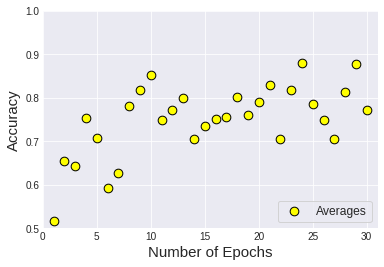

In [25]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,val_acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='lower right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim(0.5,1)

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_val_acc.png', dpi=500)

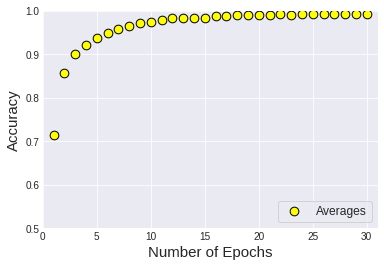

In [26]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='lower right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim(0.5,1)

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_acc.png', dpi=500)

In [22]:
prediction_generator = DataGenerator.DataGenerator(im_paths_test, im_labels_test, **params_test)  
preds = model.predict_generator(generator=prediction_generator,workers=1,steps = len(im_paths_test)//24, use_multiprocessing=False)
filenames_preds = dict(zip(prediction_generator.filenames,preds))
im_result = np.array([(im_labels_test[key],np.argmax(filenames_preds[key])) for key in filenames_preds.keys()])
confusion_matrix(im_result[:,0], im_result[:,1])

array([[ 94,  50],
       [  5, 139]])

In [25]:
print('Normalised')
confusion_matrix(im_result[:,0], im_result[:,1])/144

Normalized


array([[0.65277778, 0.34722222],
       [0.03472222, 0.96527778]])

In [26]:
print('Accuracy')
(94+139)/(94+139+55)

Accuracy


0.8090277777777778

In [ ]:
test_predictions

In [ ]:
1264+176+95+745

In [ ]:
2009/2280

In [ ]:
sample_gap